## Analyzing Consumer Financial Complaints using Watson NLP

This notebook demonstrates how to analyze consumer financial data using Watson NLP.

The data that is used in this notebook is taken from the the [Consumer complaint database](https://www.consumerfinance.gov/data-research/consumer-complaints). The dataset has been downloaded and saved in the [Box folder](https://ibm.box.com/shared/static/m9fczhrugyjgn45ez4upgntakevt7wmj.csv) for you.

### What you'll learn in this notebook
Watson NLP offers so-called blocks for various NLP tasks. This notebooks shows:

- **Syntax analysis** with the _Syntax block_ for English (`syntax_izumo_en_stock`). The syntax block performs NLP primitive tasks on the input text. It uses Izumo, the standard NLP primitives component of Watson NLP to perform the following tasks:
    1. Sentence detection
    1. Tokenization: can't -> ca + n't
    1. Part-of-Speech tagging: I thought -> I/PRON, thought/VERB
    1. Lemmatization: I thought -> I/I, thought/think
    1. Dependency parsing: I -> nsubj -> thought -> root
- **Noun Phrases** with the _Noun Phrases block_ for English (`noun-phrases_rbr_en_stock`). The Noun Phrases block extracts non-overlapping noun phrases from the input text. 
- **Keywords Extraction** with the _Text-rank_ block (`keywords_text-rank_en_stock`). The text-rank model takes the output of Noun Phrase models and assigns a relevance score for each extracted noun phrase. The relevance score calculation is inspired by the Page Rank algorithm. In the context of the input document, extracted noun phrases that appear in “more connected” contexts receive a higher rank.
- **Heirarchical Clustering** with the _HierarchicalClustering_ block. Topic Modeling consists of two models; a summary model and a topic model. Topic modeling starts with summarization after constructing a conversation structure from input data. Ngram based summaries are generated after applying refining procedures conversations. Then, the topic modeler applies hierarchical clustering using conversation vectors from the corpus of summaries.
    1. **Summary Model**: The summary model takes as input a processed syntax document (using the WatsonNLP Izumo block). Additionally, there are a number of training parameters that can be supplied alongside the syntax document to adjust the summary model. 
    
    1. **Topic Model**: Topic Model creates a tree of topics from the input data (summary model) by iteratively splitting broader topics to narrower topics (diagram below). This process is achieved using a hierarchical document clustering algorithm ((i.e. HierarchicalClustering block). Unlike other topic modeling algorithms such as Latent Dirichlet Allocation (LDA), the users do not provide fixed number of topics that may not be known to them but controls how the iterative/hierarchical topic discovery and splitting happens. This form of topic modeling is preferred over LDA when a user is not sure how many topics their dataset consists of.Three key parameters are used for this purpose: num_topics_per_iteration will determine how many topics will be extracted at each iteration of the hierarchical process. If after the first iteration there are no topics that are too large according to the king_cluster_min_ratio and min_records_per_king_cluster values and needs to be further split, then the num_topics_per_iteration will be the upper bound on the final number of topics. Otherwise, at least another iteration of the clustering will be performed to further split topics that are too large.

## Table of Contents


1.  [Before you start](#beforeYouStart)
1.	[Data Loading](#loadData)
1.  [Data Processing & EDA](#EDA)
1.  [Model Building](#loadandpredict)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
### 1. Before you start

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _Default Python 3.8 + Watson NLP XS_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>

In [2]:
%%capture
# word cloud is used to create graphs below
!pip install wordcloud
!pip install ibm-watson

In [3]:
# Silence Tensorflow warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

In [4]:
import json
import pandas as pd
from time import process_time
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import watson_nlp
from datetime import datetime

<a id="loadData"></a>
## 2. Data Loading (consumer complaints)

<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to carry out Topic modeling on any other dataset, you should first upload the dataset into the project and then update the name of the file in the next cell</div>

<span style="color:blueviolet">We load the consumer complaints into a DataFrame.</span>

<span style="color:blue">This data set contains 999285 consumer complaints with the date received, submitted via and company information.</span>

In [5]:
# load data set into a dataframe
url = "https://ibm.box.com/shared/static/m9fczhrugyjgn45ez4upgntakevt7wmj.csv"
complaint_df = pd.read_csv(url)
text_col = 'Consumer complaint narrative'

# preview the data set
complaint_df.head()

Unnamed: 0 Date received  \
0          14    2022-03-07   
1          16    2022-03-21   
2          20    2022-03-06   
3          21    2022-03-07   
4          25    2022-05-29   

                                                                                                                                                                                                                                                                                                                                                                                      Consumer complaint narrative  \
0  I have been disputing fraud accounts on my credit report since XX/XX/XXXX. I keep sending multiple sets of letters to the bureaus so the excuse of " we didn't get it '' doesn't happen. Furthermore, each letter is signed and attached with an FTC and Identity Theft affidavit, yet the bureaus are still not taking any actions. The accounts are not showing in dispute nor are they removed from my re...   
1  Beginning in XXXX of XXXX I reached out to Midland Credit to request information pertaining to a debt showing on my credit report that I did not recognize. I requested information and validation of the debt and did not receive any information or correspondents. I sent multiple letters and did not receive any of the requested information. \n\nIn XXXX of XXXX I started receiving court paper and ...   
2  On XX/XX/XXXX I was called by TD Bank ( XXXX ) XXXX which is an accurate phone number for the bank. I was told that there was suspected fraud on my account and they needed to confirm some of my transactions on my checking account. He asked for the last 4 of my SS # which I provided as this is commonly requested to verify my identity. He then proceeded to recite transactions in my account. Some...   
3  Equifax Information Services, LLC is in violation of the Fair Credit Reporting Act for refusing to have reasonable procedures in place to ensure maximum possible accuracy. I know my rights and I am being damaged by Equifax Information Services , LLC. \n1. Last week, I submitted CFPB Complaint # XXXX for the same reason I am submitting this one. \n2. Equifax Information Services, LLC chose to c...   
4  In accordance with the Fair Credit Reporting Act 15 U.S.C 1681 & Fair Debt Collection Practices Act 15 U.S.C XXXX  CKS PRIME INVESTMENTS, has violated my rights. \n( XXXX XXXX XXXX XXXX XXXX XXXX ) HAS VIOLATED MY RIGHTS. \n\n15 U.S.C XXXX  section 602 A. States I have the right to privacy.\n\n15 U.S.C XXXX  section 604 A. Section 2 : It also states a consumer reporting agency can not furnish ...   

  Submitted via                              Company  Complaint ID  
0           Web  Experian Information Solutions Inc.       5291446  
1           Web            ENCORE CAPITAL GROUP INC.       5348078  
2           Web           TD BANK US HOLDING COMPANY       5290756  
3           Web                        EQUIFAX, INC.       5295736  
4           Web             Velocity Portfolio Group       5614866

<a id="EDA"></a>
## 3. Data Processing & EDA

<span style="color:blueviolet">Convert the recieved date into date time format</span>

In [6]:
for index in range(len(complaint_df['Date received'])):
    date_str = complaint_df['Date received'][index]
    complaint_df.at[index,'Date received'] =datetime.strptime(date_str, '%Y-%m-%d')

complaint_df.head()

Unnamed: 0        Date received  \
0          14  2022-03-07 00:00:00   
1          16  2022-03-21 00:00:00   
2          20  2022-03-06 00:00:00   
3          21  2022-03-07 00:00:00   
4          25  2022-05-29 00:00:00   

                                                                                                                                                                                                                                                                                                                                                                                      Consumer complaint narrative  \
0  I have been disputing fraud accounts on my credit report since XX/XX/XXXX. I keep sending multiple sets of letters to the bureaus so the excuse of " we didn't get it '' doesn't happen. Furthermore, each letter is signed and attached with an FTC and Identity Theft affidavit, yet the bureaus are still not taking any actions. The accounts are not showing in dispute nor are they removed from my re...   
1  Beginning in XXXX of XXXX I reached out to Midland Credit to request information pertaining to a debt showing on my credit report that I did not recognize. I requested information and validation of the debt and did not receive any information or correspondents. I sent multiple letters and did not receive any of the requested information. \n\nIn XXXX of XXXX I started receiving court paper and ...   
2  On XX/XX/XXXX I was called by TD Bank ( XXXX ) XXXX which is an accurate phone number for the bank. I was told that there was suspected fraud on my account and they needed to confirm some of my transactions on my checking account. He asked for the last 4 of my SS # which I provided as this is commonly requested to verify my identity. He then proceeded to recite transactions in my account. Some...   
3  Equifax Information Services, LLC is in violation of the Fair Credit Reporting Act for refusing to have reasonable procedures in place to ensure maximum possible accuracy. I know my rights and I am being damaged by Equifax Information Services , LLC. \n1. Last week, I submitted CFPB Complaint # XXXX for the same reason I am submitting this one. \n2. Equifax Information Services, LLC chose to c...   
4  In accordance with the Fair Credit Reporting Act 15 U.S.C 1681 & Fair Debt Collection Practices Act 15 U.S.C XXXX  CKS PRIME INVESTMENTS, has violated my rights. \n( XXXX XXXX XXXX XXXX XXXX XXXX ) HAS VIOLATED MY RIGHTS. \n\n15 U.S.C XXXX  section 602 A. States I have the right to privacy.\n\n15 U.S.C XXXX  section 604 A. Section 2 : It also states a consumer reporting agency can not furnish ...   

  Submitted via                              Company  Complaint ID  
0           Web  Experian Information Solutions Inc.       5291446  
1           Web            ENCORE CAPITAL GROUP INC.       5348078  
2           Web           TD BANK US HOLDING COMPANY       5290756  
3           Web                        EQUIFAX, INC.       5295736  
4           Web             Velocity Portfolio Group       5614866

In [7]:
# Adding the columns reagarding month & year so we can extract company data through the month & year
complaint_df['Month'] = pd.DatetimeIndex(complaint_df['Date received']).month
complaint_df['Year'] = pd.DatetimeIndex(complaint_df['Date received']).year
complaint_df.head()

Unnamed: 0        Date received  \
0          14  2022-03-07 00:00:00   
1          16  2022-03-21 00:00:00   
2          20  2022-03-06 00:00:00   
3          21  2022-03-07 00:00:00   
4          25  2022-05-29 00:00:00   

                                                                                                                                                                                                                                                                                                                                                                                      Consumer complaint narrative  \
0  I have been disputing fraud accounts on my credit report since XX/XX/XXXX. I keep sending multiple sets of letters to the bureaus so the excuse of " we didn't get it '' doesn't happen. Furthermore, each letter is signed and attached with an FTC and Identity Theft affidavit, yet the bureaus are still not taking any actions. The accounts are not showing in dispute nor are they removed from my re...   
1  Beginning in XXXX of XXXX I reached out to Midland Credit to request information pertaining to a debt showing on my credit report that I did not recognize. I requested information and validation of the debt and did not receive any information or correspondents. I sent multiple letters and did not receive any of the requested information. \n\nIn XXXX of XXXX I started receiving court paper and ...   
2  On XX/XX/XXXX I was called by TD Bank ( XXXX ) XXXX which is an accurate phone number for the bank. I was told that there was suspected fraud on my account and they needed to confirm some of my transactions on my checking account. He asked for the last 4 of my SS # which I provided as this is commonly requested to verify my identity. He then proceeded to recite transactions in my account. Some...   
3  Equifax Information Services, LLC is in violation of the Fair Credit Reporting Act for refusing to have reasonable procedures in place to ensure maximum possible accuracy. I know my rights and I am being damaged by Equifax Information Services , LLC. \n1. Last week, I submitted CFPB Complaint # XXXX for the same reason I am submitting this one. \n2. Equifax Information Services, LLC chose to c...   
4  In accordance with the Fair Credit Reporting Act 15 U.S.C 1681 & Fair Debt Collection Practices Act 15 U.S.C XXXX  CKS PRIME INVESTMENTS, has violated my rights. \n( XXXX XXXX XXXX XXXX XXXX XXXX ) HAS VIOLATED MY RIGHTS. \n\n15 U.S.C XXXX  section 602 A. States I have the right to privacy.\n\n15 U.S.C XXXX  section 604 A. Section 2 : It also states a consumer reporting agency can not furnish ...   

  Submitted via                              Company  Complaint ID  Month  \
0           Web  Experian Information Solutions Inc.       5291446      3   
1           Web            ENCORE CAPITAL GROUP INC.       5348078      3   
2           Web           TD BANK US HOLDING COMPANY       5290756      3   
3           Web                        EQUIFAX, INC.       5295736      3   
4           Web             Velocity Portfolio Group       5614866      5   

   Year  
0  2022  
1  2022  
2  2022  
3  2022  
4  2022

In [8]:
# To see how the companies are getting complaints 
exp_company = complaint_df.explode('Company')

<span style="color:purple">Extract most frequent companies in the dataset</span>

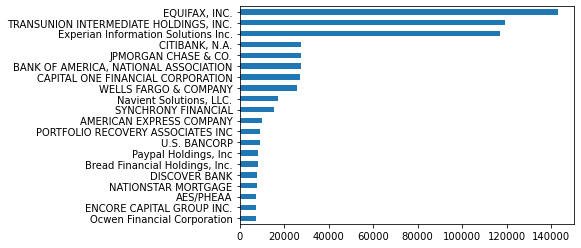

In [9]:
top_company_names =exp_company['Company'].value_counts().head(20)
top_company_names.sort_values().plot(kind='barh') 
plt.show()

In [10]:
print(top_company_names)

EQUIFAX, INC.                             143202
TRANSUNION INTERMEDIATE HOLDINGS, INC.    119124
Experian Information Solutions Inc.       116763
CITIBANK, N.A.                             27583
JPMORGAN CHASE & CO.                       27552
BANK OF AMERICA, NATIONAL ASSOCIATION      27486
CAPITAL ONE FINANCIAL CORPORATION          26980
WELLS FARGO & COMPANY                      25993
Navient Solutions, LLC.                    17146
SYNCHRONY FINANCIAL                        15676
AMERICAN EXPRESS COMPANY                   10153
PORTFOLIO RECOVERY ASSOCIATES INC           9318
U.S. BANCORP                                9277
Paypal Holdings, Inc                        8248
Bread Financial Holdings, Inc.              8136
DISCOVER BANK                               7715
NATIONSTAR MORTGAGE                         7607
AES/PHEAA                                   7413
ENCORE CAPITAL GROUP INC.                   7322
Ocwen Financial Corporation                 7268
Name: Company, dtype

## Text Pre-Processing
Our first step is to pre-process the documents in a way that cleans distracting signals and makes them easier to process and analyze. This is a standard step in many NLP pipelines. Here we perform two types of pre-processing:

1. Stop-words filtering
1. Lemmatization

### Stop-Words Filtering
Stop-words are common words that are unmeaningful for separating the data. Such common words are assumed to be "noise" as their high frequency could hide the words carrying more informative signal. We filter them based on a pre-defined list used in WatsonNLP and based on the part-of-speech. Notes:

1. The stop-words list can be customized for the target dataset. We demonstrate this below.
1. When we vectorize the documents below, we apply a filter that ignores terms that appear in 50% or more of the documents. This filter can also be counted as part of stop-words filtering.

### Remove some Patterns
   1. This dataset has consumer personal information also . that is hide by Pattern of 'XX/XX/XXXX' or other date . So replacing this pattern as well.

### Lemmatization
Variability in surface forms, as in derivation (drive, driving, drives) and inflection (am, is, are), creates a challenge for a clustering algorithm that works on top of term frequency (TF) representations since in this setup the algorithm is not aware of the strong semantic relation between them. By lemmatizing the data, we group together different word forms by their lemma, thus ignoring subtle differences between them, but capturing their common concept. Example of lemmatization:

1. Derivation: all instances of drive, driving and drives would become drive
1. Inflection: all instances of am, is, are would become be

We rely on WatsonNLP's stock list of stop-words and customize it. For example, we might assume that a word like 'keep' can be useful for separating the data, so we remove it from the list. In addition, we might want to add a few other words to the list. For instance, common informal contractions that aren't part of the stock list.

In [11]:
wnlp_stop_words = watson_nlp.download_and_load('text_stopwords_classification_ensemble_en_stock').stopwords
stop_words = list(wnlp_stop_words)
stop_words.remove('keep')
stop_words.extend(["gimme", "lemme", "cause", "'cuz", "imma", "gonna", "wanna", 
                   "gotta", "hafta", "woulda", "coulda", "shoulda", "howdy","day"])

<span style="color:purple">Define a custom list of Izumo part-of-speech tags that will be used for filtering</span>

In [12]:
pos_filter = {
    4,      # POS_AUX
    10,     # POS_PART
    11,     # POS_PRON
    15,     # POS_SYM
    17      # POS_X
}

<span style="color:purple">Now we define a tokenizer that implements the pre-processing as explained above. The input for the tokenizer is the document text and the output is a list of lemmas, while ignoring stop-words.</span>

In [13]:
# load the syntex model
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))

In [14]:
def custom_tokenizer(text):
    # parse the text for pos tagging and lemmatization
    result = syntax_model.run(text, parsers=('part_of_speech', 'lemma'))

    # collect the terms that qualify as meaningful.
    # to qualify, a term must meet all conditions:
    # (a) not be pos-tagged as symbol / content-less word
    # (b) not be a stop-word from the pre-defined list
    # (c) be longer than 1 character
    terms = []
    for token in result.tokens:
        pos_tag = token.part_of_speech
        if pos_tag not in pos_filter:
            lemma = token.lemma.strip()
            text = token.span.text.strip()
            term = lemma if len(lemma) > 0 else text
            if len(term) >1:
                terms.append(term)
    return " ".join(terms)

In [15]:
# Pre-processing steps for document level only remove stop words  & Patterns which is find they are comman
def clean(doc):
    stop_free = " ".join([word.replace('X','').replace('/','') for word in doc.split() if word.lower() not in stop_words])
    return stop_free

### Phrase & Keywords Extraction 

1. The Noun Phrases block extracts non-overlapping noun phrases from the input text. For example, in the text:

    ```Anna went to school at University of California Santa Cruz```
    the noun phrases extracted are: Anna, school, University of California Santa Cruz.

2. The keywords block ranks noun phrases extracted from an input document based on how relevant they are within the document. For example, in the text

    ```Anna went to school at University of California Santa Cruz. 
    Anna joined the university in 2015.```
   
    a Keywords model may decide that noun phrases Anna and University of California Santa Cruz are more relevant than school and university.

In [16]:
# getting names of top companies 
top_company_names_list =[]
for index,row in top_company_names.items():
    top_company_names_list.append(index)
    
print(top_company_names_list[0]) 

EQUIFAX, INC.


In [17]:
# extarct company data through the company name 
def extarct_company_data(company_name):
    top_doc_list =[]
    for index, row in complaint_df.iterrows():
        if row['Company'] == company_name:
            top_doc_list.append(row['Consumer complaint narrative']) 
    return top_doc_list
    

In [18]:
top_doc_list = extarct_company_data(top_company_names_list[0])

In [19]:
len(top_doc_list)

143202

In [20]:
# Keyword Extraction
# Load Noun Phrases, Embedding and Keywords models for English
noun_phrases_model = watson_nlp.load(watson_nlp.download('noun-phrases_rbr_en_stock'))
keywords_model = watson_nlp.load(watson_nlp.download('keywords_text-rank_en_stock'))

<span style="color:purple">Apply pre-processing steps to whole data before processing to extract the keywords & Noun Phrases</span>

In [21]:
top_complaint_df = [clean(doc) for doc in top_doc_list] 

In [22]:
from watson_nlp import data_model as dm1 
import time
def extract_keywords(text):
    # Run the Syntax and Noun Phrases models
    syntax_prediction = syntax_model.run(text, parsers=('token', 'lemma', 'part_of_speech'))
    noun_phrases = noun_phrases_model.run(text)
    # Run the keywords model
    keywords = keywords_model.run(syntax_prediction, noun_phrases, limit=5)  
    keywords_list =keywords.to_dict()['keywords']
    key_list=[]
    for i in range(len(keywords_list)):
        key = custom_tokenizer(keywords_list[i]['text'])
        key_list.append(key)
    return {'Complaint data':text,'Phrases':key_list}

In [23]:
keywords = [extract_keywords(doc) for doc in top_complaint_df]

In [24]:
phrases_df = pd.DataFrame(keywords)

In [25]:
phrases_df.head()

Complaint data  \
0  Equifax Information Services, LLC violation Fair Credit Reporting Act refusing reasonable procedures place ensure maximum accuracy. rights damaged Equifax Information Services , LLC. 1. week, submitted CFPB Complaint #  reason submitting one. 2. Equifax Information Services, LLC chose continue harass refuse delete inaccurate information consumer file consumer reports, refused provide full 609 ...   
1  30 days filed dispute inaccurate false information credit report. Ive attached copy dispute mailed certified Equifax reporting incorrect items. fair credit ACT, section 609 ( ) ( 1 ) ( ) required Federal Law report Accurate information so. provided proof i.e. original consumer contract signature proving account. more, make formal complaint Ive calling Equifax 10 times week single time Ive call...   
2  Concern, advised received computer-generated letter stating ceased investigation credit reports because, opinion, third-party credit repair agency. stall tactic part grant additional 30 days comply original request, blatant violation FCRA. advised 2022 certified mail questioned accuracy items credit reports. request written mailed me- third-party agency. appears obvious abusing power FCRA esca...   
3                                                                                                                                                                                                                                                    dispute Equifax year fraudulent disputes inquires. lied numerous times receiving documents received them. FTC reports attached email. excuse remove inquiries   
4  Hi, scammed years ago online. hurt mentally financially. heavy . scammed online gift card scam.   credit card scam. unable access account anymore. company data purchases. gift cards bought else. fooled scammed buying them. admitting bought cards, me. puppet person. tricked buying cards redeemed digitally.  cards. years, remember company gift cards exact dates them. bank statements show purchas...   

                                                                                                                Phrases  
0                    [Equifax Information Service, LLC violation, right, fair credit, information consumer file entity]  
1       [formal complaint Ive, representative fraud dispute department transfer, time week, single time Ive, Im Making]  
2  [computer generate letter, notice letter, investigation credit, time error account violation, United State Congress]  
3                                                      [fraudulent dispute, Equifax year, numerous time, FTC, document]  
4                               [scammed year, bank statement, online gift card scam, company data purchase, gift card]

In [26]:
exp_phrases = phrases_df.explode('Phrases')

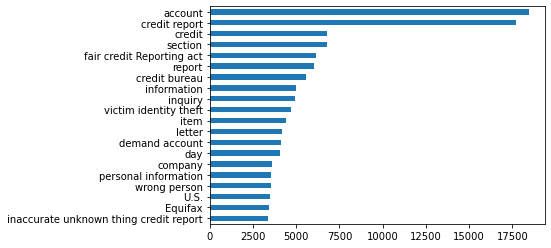

In [27]:
exp_phrases['Phrases'].value_counts().head(20).sort_values().plot(kind='barh') 

plt.show()

<span style="color:purple">Create a word cloud of the extracted keywords</span>

In [28]:
# Create a Word Cloud 
def create_word_cloud(top_level_cat_df,text):
    figure, ax1 = plt.subplots(ncols=1, figsize=(10,6))
    wc = WordCloud(width=600, height=400, background_color ='white').generate_from_frequencies(top_level_cat_df.value_counts().head(20))
    ax1.imshow(wc, interpolation="bilinear")
    ax1.axis('off')
    ax1.title.set_text(text)
    plt.show()

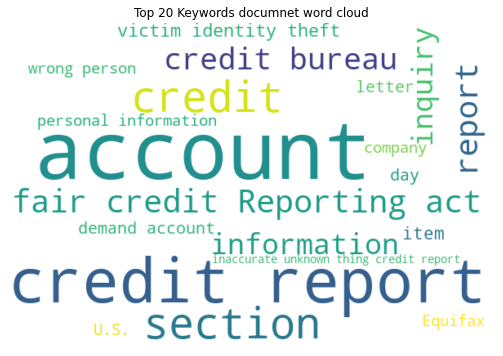

In [29]:
create_word_cloud(exp_phrases['Phrases'],"Top 20 Keywords documnet word cloud")

<a id="loadandpredict"></a>
## 4. Model Building

<span style="color:purple">Import required libraries for Topic modeling</span>

In [30]:
from watson_nlp.toolkit import NGramSummary
from watson_nlp.blocks.topics import HierarchicalClustering
from watson_core import data_model as dm

<span style="color:purple">Loaded stopwords list for using topic modling</span>

In [31]:
buffer = project.get_file("stopwords.txt")
topic_model_stopwords = pd.read_csv(buffer,delimiter="\n",encoding='utf-8')

In [32]:
train_params = {
    "min_words_per_utterance": 5,
    "num_turns_to_remove": 0,
    "beginning_ratio": 1,
    "beginning_weighting_factor": 1,
    "min_ngram_size": 2,
    "max_ngram_size": 3,
    "max_ngrams": 10,
    'stopwords': list(topic_model_stopwords)
}

<span style="color:purple">Convert dataframe into the required format for training the model</span>

In [33]:
complaint_df_up = pd.DataFrame(top_complaint_df)
train_file = './train_data.csv'
complaint_df_up.to_csv(train_file)

complaint_df_up.head()

0
0  Equifax Information Services, LLC violation Fair Credit Reporting Act refusing reasonable procedures place ensure maximum accuracy. rights damaged Equifax Information Services , LLC. 1. week, submitted CFPB Complaint #  reason submitting one. 2. Equifax Information Services, LLC chose continue harass refuse delete inaccurate information consumer file consumer reports, refused provide full 609 ...
1  30 days filed dispute inaccurate false information credit report. Ive attached copy dispute mailed certified Equifax reporting incorrect items. fair credit ACT, section 609 ( ) ( 1 ) ( ) required Federal Law report Accurate information so. provided proof i.e. original consumer contract signature proving account. more, make formal complaint Ive calling Equifax 10 times week single time Ive call...
2  Concern, advised received computer-generated letter stating ceased investigation credit reports because, opinion, third-party credit repair agency. stall tactic part grant additional 30 days comply original request, blatant violation FCRA. advised 2022 certified mail questioned accuracy items credit reports. request written mailed me- third-party agency. appears obvious abusing power FCRA esca...
3                                                                                                                                                                                                                                                    dispute Equifax year fraudulent disputes inquires. lied numerous times receiving documents received them. FTC reports attached email. excuse remove inquiries
4  Hi, scammed years ago online. hurt mentally financially. heavy . scammed online gift card scam.   credit card scam. unable access account anymore. company data purchases. gift cards bought else. fooled scammed buying them. admitting bought cards, me. puppet person. tricked buying cards redeemed digitally.  cards. years, remember company gift cards exact dates them. bank statements show purchas...

In [34]:
csv_stream = dm.DataStream.from_csv(train_file, skip=1)
syntax_data = syntax_model.stream(csv_stream[1])

### Training a Summary Model 

<span style="color:purple"> Train a summary model using the <strong> izumo syntax data</strong> as data inputs.</span>

A summary model consists of a mapping of words to their occurrences over all of the documents

Additionally, the summary model can be provided a dictionary of parameters to modify the summary model that is trained. 

<span style="color:purple">These train parameters are: </span>
    <p>1. min_words_per_utterance: int, documents with fewer words than this value are removed</p>
    <p>2. num_turns_to_remove: int, initial number of turns to be removed from analysis (useful in conversation kind of data where initial few turns are typically greetings)</p>
    <p>3. beginning_ratio: int ratio of the document from the beginning to be weighted differently </p>
    <p>4. beginning_weighting_factor: int, weighting factor for the beginning portion of the training procedure</p>
    <p>5. beginning_min_count: int, minimum count of ngrams for beginning portion of the training procedure</p>
    <p>6. rest_weighting_factor: int, weighting factor for the remaining portion of the training procedure</p>
    <p>7. rest_min_count: int, minimum count of ngrams for the remaining portion of the training procedure</p>
    <p>8. min_ngram_size: int, minimum size of list of ngrams to generate summaries for each document</p>
    <p>9. max_ngram_size: int, maximum size of list of ngrams to generate summaries for each document</p>
    <p>10. max_ngrams: int, maximum number of ngrams for each document summary</p>
    <p>11. lang: str, language</p>
    <p>12. stopwords: list, set of stopwords for the model to ignore when generating topic clusters</p>

<span style="color:purple">These are supplied as a dictionary the the train_params parameter. E.g. </span>

>{
>    'min_words_per_utterance': 5,
>    'num_turns_to_remove': 0,
>    'beginning_ratio': 1,
>    'beginning_weighting_factor': 1,
>    'min_ngram_size': 5,
>    'max_ngram_size': 8,
>    'max_ngrams': 10,
>}

In [35]:
summary_model = NGramSummary.train(train_data=syntax_data,train_params=train_params)

You can look into some of the details of the summary model such as the specifications of the model. For example: summary_model.model.get_n_grams() will return information about the length of the n-grams. The n-grams are the set of tokens

><p>max_N_gram_size: int, max length of the n-grams for each document e.g. if set to 5: ['I', 'was', 'travelling', 'last', 'week'] (n-gram length = 5)</p>
><p>min_N_gram_size: int, min length of the n-grams for each document e.g. if set to 3: ['bank', 'account', 'issue'] (n-gram length = 3)</p>
><p>max_N_grams: int, maximum number of n-grams for each document e.g 10 </p>

In [36]:
summary_model.model.get_n_grams()

{'max_N_gram_size': 3, 'min_N_gram_size': 2, 'max_N_grams': 10}

### Training a Topic Model
<span style="color:purple">Train a topic model by supplying the izumo <strong>syntax data and the summary model</strong></span>

Optional model parameters can be supplied to train the topic model: 

1. num_topics_per_iteration: int, number of topics for each run (fixed across all runs)

2. king_cluster_min_ratio: float, define cluster as a king cluster if the percentage of documents belonging to a specific cluster is greater than this value. A king cluster can be considered a "most prominent" cluster that other clusters would be correlated with

3. min_records_per_king_cluster: int, define cluster as a king cluster if the number of documents belonging to a specific cluster is greater than this value

4. max_num_iters_per_model: int, maximum number of iterations

5. min_word_support: float, minimum word support for each run of the model

6. max_word_support: float, maximum word support for each run of the model

7. max_ngrams_per_topic: int, maximum number of ngrams per topic</ol>

<span style="color:purple">These parameters can be supplied to the train() function as a dictionary such as below:</span>

>train_params = {
>    'king_cluster_min_ratio': .5,
>    'min_records_per_king_cluster': 10,
>    'num_topics_per_iteration': 40,
>    'max_num_iters_per_model': 4,
>    'min_word_support': 0.01,
>    'max_word_support': 0.7,
>    'max_ngrams_per_topic': 10,
>}

In [37]:
topic_model = HierarchicalClustering.train(train_data=syntax_data, 
                                           summary_model=summary_model,
                                           train_params = {'king_cluster_min_ratio': .5, 
                                                           'min_records_per_king_cluster': 4000,
                                                           'num_topics_per_iteration': 40,
                                                           'max_num_iters_per_model': 4,
                                                           'max_ngrams_per_topic':10})

<span style="color:purple">Showing result of Topic Model with only First cluster</span>

In [38]:
topic_model_output =topic_model.model.to_json_summary()
print(json.dumps(topic_model_output['clusters'][0], indent=2))

{
  "clusterId": 0,
  "numDocuments": 1517.0,
  "percentage": 1.550474749849245,
  "cohesiveness": 61.92356044919215,
  "modelWords": [
    "Credit (Credit),0.937652051448822",
    "report (report),0.011950643733143806",
    "score (score),0.008536161854863167",
    "Bureaus (Bureaus),0.005458313971757889",
    "card (card),0.004115946125239134"
  ],
  "modelNgram": [
    "report credit,9.091968399559368",
    "bureaus credit,7.318574802223661",
    "score credit,6.592953558115232",
    "credit card,6.300050508307578"
  ],
  "modelId": 0,
  "topicName": "ran_credit_give_permission",
  "sentences": [
    "born , credit report states born , Equifax , husband 's girlfriend refuses return divorce papers tax returns bad credit lack credit .",
    "opt - promotional offers stop inquiries loans credit cards offers se credit report .",
    "put security measure finances credit report , including services offered equifax , .",
    ": - - - Dba forms credit established creditors above , investig

<span style="color:purple">Extract all the Topic names , Keywords , Phrases & Sentences from the Topic Model</span>

In [39]:
#  Extracting all Topic names , Keywords , Phrases & Sentences from the Topic Model
def extract_topics_information(topic_model_output):
    topic_dict=[]
    for topic in topic_model_output['clusters']:
        topic_val = {'Topic Name':topic['topicName'],'Total Documents':topic['numDocuments'],'Percentage':topic['percentage'],'Cohesiveness':topic['cohesiveness'],'Keywords':topic['modelWords'],'Phrases':topic['modelNgram'],'Sentences':topic['sentences']}
        topic_dict.append(topic_val)
    return topic_dict


### Showing Top Topics with Keywords , Pharses & Sentecnes

<span style="color:purple">Convert the dictionary created above into a dataframe</span>

In [40]:
# Convert topic_dict into data frame to see which are the most imprtnat topics with Keywords & Phrases & SENTENSES (SORT BY Percentage)
topic_df = pd.DataFrame(extract_topics_information(topic_model_output))
topic_df=topic_df.sort_values("Percentage",ascending=False)
topic_df.head()


Topic Name  Total Documents  Percentage  Cohesiveness  \
1    Fair_Credit_Reporting          13091.0   13.379871      0.160723   
11   credit_file_reporting           7011.0    7.165708      0.592819   
2    credit_report_removed           6873.0    7.024662    112.897522   
26   credit_report_account           6234.0    6.371562      0.250004   
28  accounts_credit_report           4993.0    5.103178      0.288483   

                                                                                                                                                                                                        Keywords  \
1   [Credit (Credit),0.039192624390125275, letter (letter),0.03010331280529499, collection (collection),0.027851253747940063, received (received),0.025952840223908424, Security (Security),0.02427545376121998]   
11                            [Credit (Credit),0.41602015495300293, file (file),0.04825935512781143, score (score),0.04093183949589729, card (card),0.03755248337984085, reports (reports),0.037237003445625305]   
2                     [Credit (Credit),0.4770258367061615, report (report),0.471426397562027, items (items),0.007274234667420387, Equifax (Equifax),0.005438877735286951, listed (listed),0.0031080730259418488]   
26             [account (account),0.23346053063869476, Credit (Credit),0.06669334322214127, Reporting (Reporting),0.035193588584661484, report (report),0.03159324452280998, Number (Number),0.0310443714261055]   
28        [report (report),0.2123420238494873, Credit (Credit),0.15764519572257996, ACCOUNTS (ACCOUNTS),0.03713270649313927, Reporting (Reporting),0.027943449094891548, Equifax (Equifax),0.023798758164048195]   

                                                                                                                                                                                                                                                                                                                                                                                              Phrases  \
1                                                                                                                 [letter received,0.2844947200365535, collection credit,0.18588510042081818, letter Credit,0.15955979199122633, received credit,0.1500029756964451, Letter Collection,0.12051313322084574, letter received collection,0.058160182435673446, received collection,0.03729415603916913]   
11                      [file credit,3.4474415219636767, reports credit,3.2086910024806916, score credit,3.1840000069022154, credit card,3.0342191899109676, score file credit,0.9052172195655582, file credit card,0.80766743594796, score credit card,0.5432686961440618, reports credit card,0.5392095038546191, reports file credit,0.34762475735510534, score reports credit,0.3425457105543351]   
2                                                                                                       [report credit,9.08095331469697, Equifax Report Credit,6.202953628023585, report credit items,5.614826802638507, listed report credit,4.898151426151448, Equifax report,2.8849078096045577, Equifax credit,2.644214893106881, report items,2.411192395285165, credit items,2.225416871390345]   
26  [report credit account,2.01624030079776, Number Account,1.7924193183588384, credit account,1.5962543178091069, reporting account,1.5530205576913159, report account,1.3734512920747022, credit Account reporting,1.3051120612652782, number reporting account,1.0739752170690575, report credit,0.941044664691456, Number report Account,0.9410158489216822, Credit Reporting,0.8525185348833908]   
28  [report credit,3.5424416186450123, Equifax Report Credit,2.5607075362435627, report accounts credit,2.341986947403422, report credit reporting,2.0366067000083574, Credit Reporting,1.5528758866818775, Equifax report,1.4285887890919227, report accounts,1.3804408505810224, accounts credit,1.0103881252452604, Equifax credit,0.99442879607

In [41]:
# Topic Distribution by Topic Weights
import plotly.express as px
fig = px.bar(topic_df, x="Topic Name", y=["Percentage"], title="Number of Documents by Topic Weightage")
fig.show()

In [42]:
def create_topic_pie_chart(sizes,labels):
    fig1, ax1 = plt.subplots(figsize=(15,5))
    fig1.subplots_adjust(0.2,0,1,1)
    theme = plt.get_cmap('bwr')
    ax1.set_prop_cycle("color", [theme(1. * i / len(sizes)) for i in range(len(sizes))])
    _,_,_ = ax1.pie(sizes, autopct='%1.1f%%',startangle=90)
    ax1.axis('equal')
    total = sum(sizes)
    plt.legend(
        loc='upper left',
        labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],

    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
    )
    plt.show()

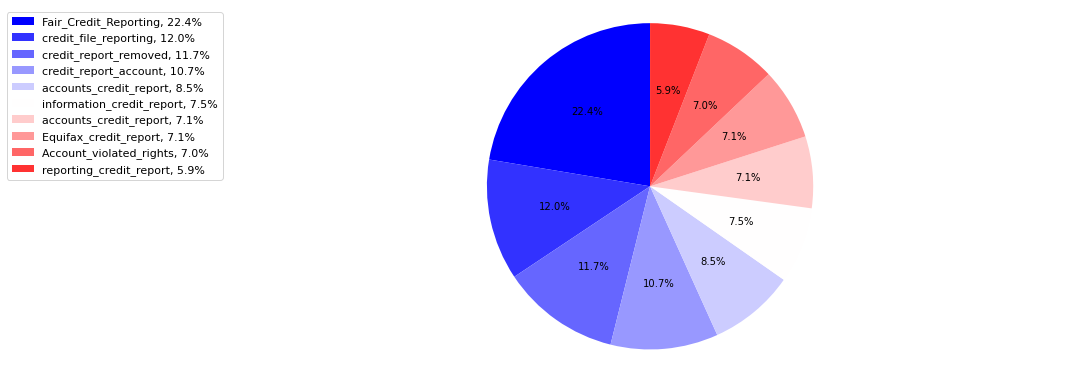

In [43]:
topic_names = topic_df['Topic Name'].head(10)
percentage = topic_df['Percentage'].head(10)
create_topic_pie_chart(list(percentage),list(topic_names))

In [44]:
# Most Important top N keywoprds & Phrases 
# See Top -5 Topics Keywords & Phrases 
import matplotlib.colors as mcolors
def create_keywords_dict(keywords):
    keywords_list =[]
    for keys in keywords:
        dic ={}
        for key in keys:
            key_value = key.split(',')
            dic[key_value[0].split('(')[0]] = float(key_value[1])
        keywords_list.append(dic)
    return keywords_list

def plot_wordcloud_top10_topics(keywords_list,topic_names):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
    cloud = WordCloud(background_color='white',width=2500,height=1800,max_words=10,colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
    fig, axes = plt.subplots(1,5, figsize=(25,10), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = keywords_list[i]
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title(topic_names[i], fontdict=dict(size=16))

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()


#### Most Frequent Keywords & Phrases of top 5 Topics

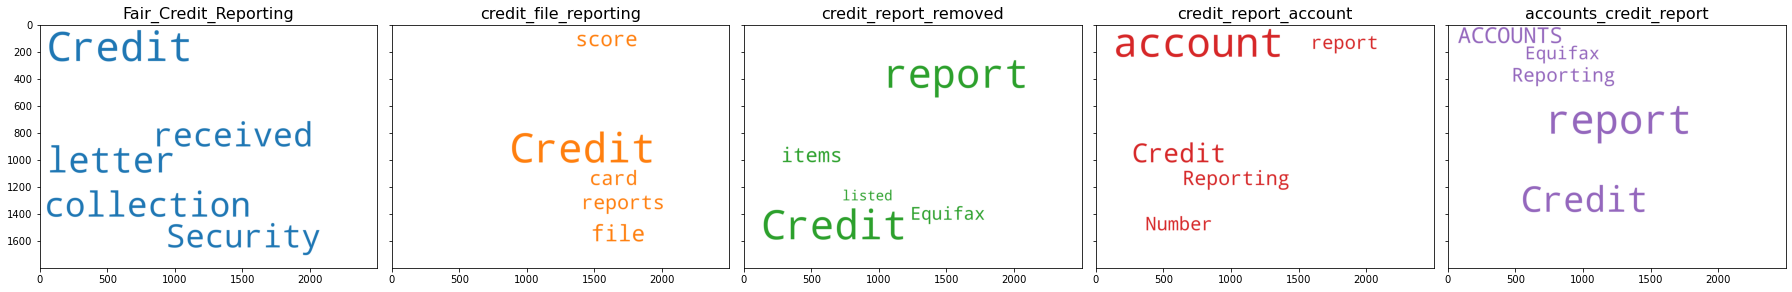

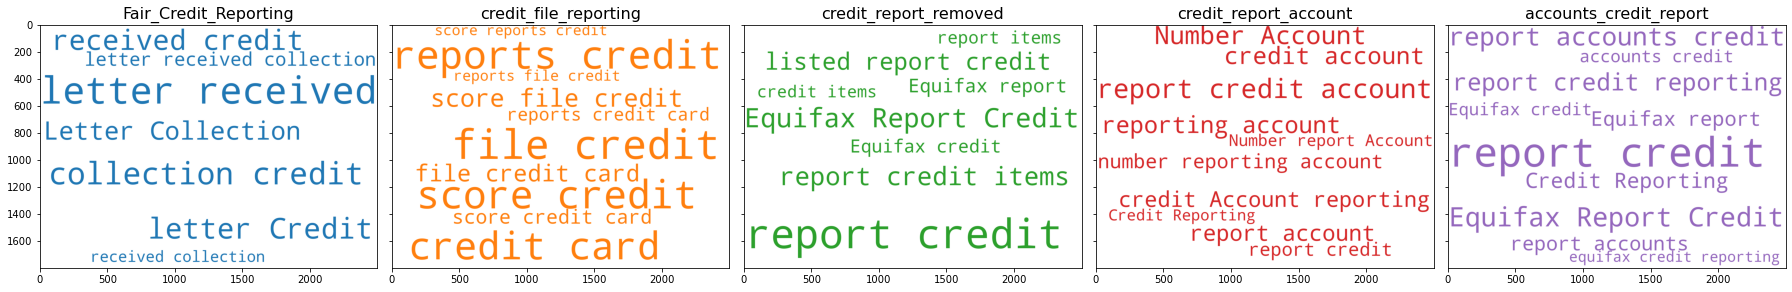

In [45]:

keywords = topic_df['Keywords'].head(5)
phrases = topic_df['Phrases'].head(5)
topic_names_val = topic_df['Topic Name'].head(5)
keywords_list =create_keywords_dict(keywords)
phrases_list =create_keywords_dict(phrases)
plot_wordcloud_top10_topics(keywords_list,list(topic_names_val))
plot_wordcloud_top10_topics(phrases_list,list(topic_names_val))


 ### Test the model

In [46]:
new_text = "ECSI, a collection agency, reached out to me on behalf of an old debt to my XXXX XXXX XXXX In XX/XX/XXXX, \
I paid ECSI {$980.00}. The rep at the end of the call told me my account was paid in full and I would receive a letter in the mail stating as much.\
The letter I received from ECSI dated XX/XX/XXXX now has a past due balance of {$130.00}. I called ECSI at XXXX and they said I now owe a balance of {$250.00}. \
I do not understand how it is possible I owe additional money when I was told by their representative the balance had been paid in full in XXXX.\
I do not understand at all what they are even charging me for. I requested an itemized statement which I have not yet received. \
The ECSI rep indicated itemized statements could be obtained on their website at heartland.ecsi.net, however, I am unable to access. \
I graduated  from XXXX XXXX  in XXXX and have taken proper steps to remedy this debt, however, this company is trying to scam me out of even more money with no explanation!\
I would like for this company to provide an itemized statement, an explanation for how I was given a wrong total amount due in XXXX, and/or forgive the remaining balance down to zero.\
I would also like to note this company 's practices seem unethical as they do not make it clear they are a debt collection agency as required by the FDCPA. \
The representative insisted she was XXXX XXXX even though XXXX XXXX verified they are a third party collection agency. \
They also sent a letter on XXXX XXXX XXXX letter head, which again, seems fishy. Please help, thank you."

text_syntax = syntax_model.run(new_text)

topic_model_1_prediction = topic_model.run(text_syntax)

#print(topic_model_1_prediction.to_dict()['topics'])
print(topic_model_1_prediction.topics[0].name)

Fair_Credit_Reporting


## Save Model

In [47]:
topic_model.save('complaint_topic_model')
project.save_data('complaint_topic_model', data=topic_model.as_file_like_object(), overwrite=True)

saving modelcomplaint_topic_model/./topic_model_data.model/model_0/kMeansModel
saving model/tmp/wsuser/tmpde6625w8/.model/./topic_model_data.model/model_0/kMeansModel


{'file_name': 'complaint_topic_model',
 'message': 'File saved to project storage.',
 'bucket_name': 'watsoncore-donotdelete-pr-olkxvfa8bk0pb1',
 'asset_id': '67fed7ca-a274-42ee-8d76-f70c79c2bc2a'}

In [48]:
topic_model2 = watson_nlp.load('complaint_topic_model')

Loadding from complaint_topic_model/./topic_model_data.model/model_0/kMeansModel
com.ibm.research.conversation_analytics.datamodel.clustering.WNClusteringModel@28181a35


In [49]:

topic_model_2_prediction = topic_model2.run(text_syntax)

#print(topic_model_1_prediction.to_dict()['topics'])
print(topic_model_2_prediction.topics[0].name)

Fair_Credit_Reporting


###  Analyzing hot topics for 2 companies from the dataset

In [50]:
# Initalizing a train parames for company
train_params1 = {
    'min_words_per_utterance': 5,
    'num_turns_to_remove': 0,
    'beginning_ratio': 1,
    'beginning_weighting_factor': 1,
    'min_ngram_size': 2,
    'max_ngram_size': 3,
    'max_ngrams': 10,
    'stopwords': list(topic_model_stopwords)
}

In [51]:
# Creating a topic modeling method which can run all steps and retrun Topic Model outp
def create_topic_modeling(company_data):
    complaint_company_df= pd.DataFrame(company_data)
    train_file = './train_data.csv'
    complaint_company_df.to_csv(train_file)
    csv_stream = dm.DataStream.from_csv(train_file, skip=1)
    syntax_data = syntax_model.stream(csv_stream[1])
    summary_model = NGramSummary.train(train_data=syntax_data,train_params=train_params1)
    topic_model_1 = HierarchicalClustering.train(train_data=syntax_data, 
                                           summary_model=summary_model,
                                           train_params = {'king_cluster_min_ratio': .5, 
                                                           'min_records_per_king_cluster': 4000,
                                                           'num_topics_per_iteration': 40,
                                                           'max_num_iters_per_model': 4,
                                                           'max_ngrams_per_topic':10})
    return topic_model_1.model.to_json_summary()
    


In [52]:
print(" Processing shows Company Name --- ",top_company_names_list[1])

 Processing shows Company Name ---  TRANSUNION INTERMEDIATE HOLDINGS, INC.


In [53]:
top_doc_list = extarct_company_data(top_company_names_list[1])
top_complaint_df_2 = [clean(doc) for doc in top_doc_list] 
topic_model_1 =create_topic_modeling(top_complaint_df_2)

In [54]:
# Convert topic_dict into data frame to see which are the most imprtnat topics with Keywords & Phrases & SENTENSES (SORT BY Percentage)
topic_df_1 = pd.DataFrame(extract_topics_information(topic_model_1))
topic_df_1=topic_df_1.sort_values("Percentage",ascending=False)


In [55]:
print("Company Name ---",top_company_names_list[3])

Company Name --- CITIBANK, N.A.


In [56]:
# Third Company
top_doc_list = extarct_company_data(top_company_names_list[3])
top_complaint_df_2 = [clean(doc) for doc in top_doc_list]
topic_model_2 =create_topic_modeling(top_complaint_df_2)

In [57]:
# Convert topic_dict into data frame to see which are the most imprtnat topics with Keywords & Phrases & SENTENSES (SORT BY Percentage)
topic_df_2= pd.DataFrame(extract_topics_information(topic_model_2))
topic_df_2=topic_df_2.sort_values("Percentage",ascending=False)

In [58]:
# Showing comparision chart of top two compnies topics 
fig = px.bar(topic_df_1.head(10), x="Topic Name", y=["Percentage"], title="Top 10 Topic Names")
fig.show()

<span style="color:blue">The most frequent customer complain for the Transunion is related to the department told information and credit report.</span>

In [59]:
fig = px.bar(topic_df_2.head(10), x="Topic Name", y=["Percentage"], title="Top 10 Topic Names")
fig.show()

<span style="color:blue">The most frequent customer complain for the Citi Bank is related to the claims and checking account.</span>

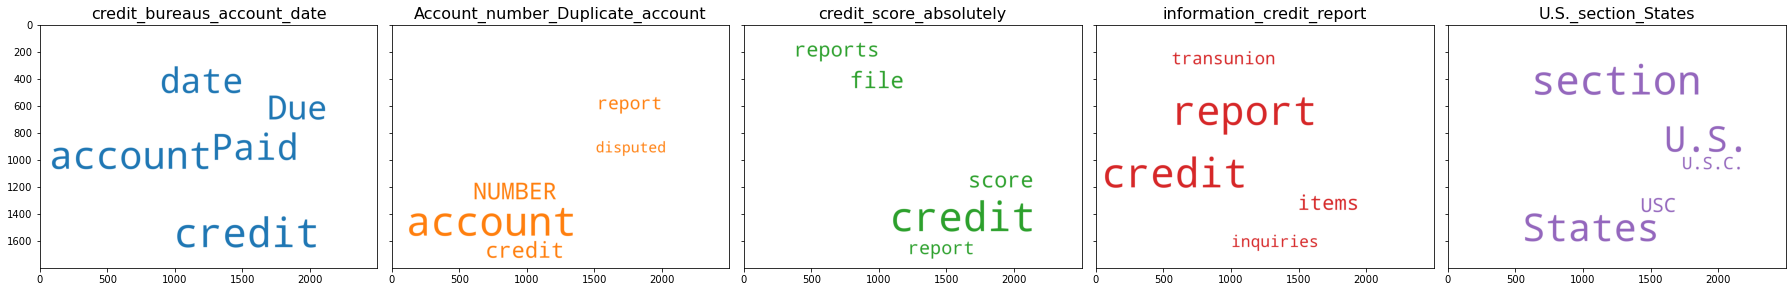

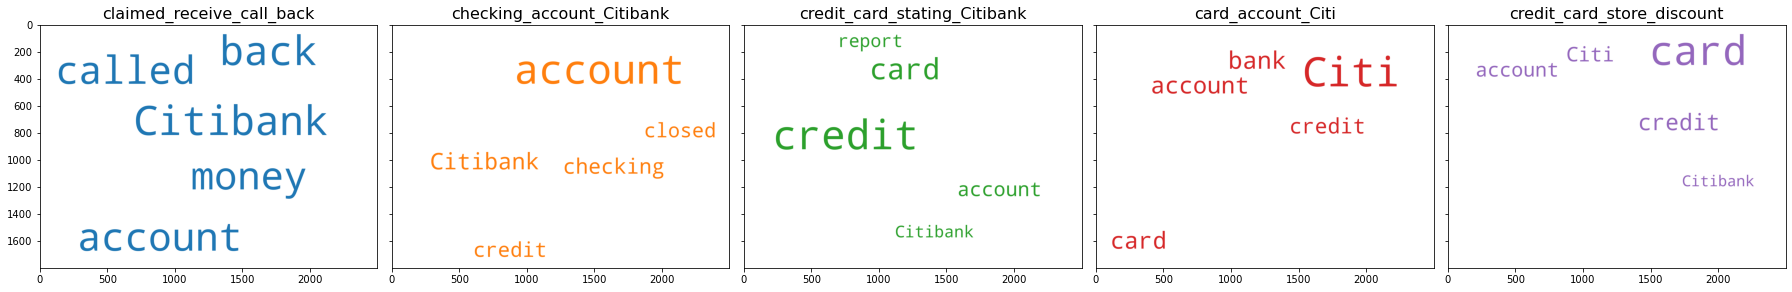

In [60]:
keywords = topic_df_1['Keywords'].head(5)
phrases = topic_df_2['Keywords'].head(5)
topic_names_1 = topic_df_1['Topic Name'].head(5)
topic_names_2 = topic_df_2['Topic Name'].head(5)
keywords_list =create_keywords_dict(keywords)
phrases_list =create_keywords_dict(phrases)
plot_wordcloud_top10_topics(keywords_list,list(topic_names_1))
plot_wordcloud_top10_topics(phrases_list,list(topic_names_2))

<span style="color:blue">The most frequent customer complain for Transunion is related to the dispute letter and the credit report information whereas for the Citi Bank, the most frequent customer complain is related to the claims and checking account.</span>

### Analysis company topics & phrases month wise

In [61]:
# Extract company data through the company name & month, For example if you want to search for the March month data then enter month =3 
def extract_month_company_data(company_name, month):
    top_doc_list =[]
    for index, row in complaint_df.iterrows():
        if row['Company'] == company_name and row['Month'] == month:
            top_doc_list.append(row['Consumer complaint narrative']) 
    return top_doc_list

In [62]:
# Third Company 
top_doc_list = extract_month_company_data(top_company_names_list[3],3)
len(top_doc_list)

2518

In [63]:
top_complaint_df_month = [clean(doc) for doc in top_doc_list] 
topic_model_month =create_topic_modeling(top_complaint_df_month)
topic_df_month= pd.DataFrame(extract_topics_information(topic_model_month))
topic_df_month=topic_df_month.sort_values("Percentage",ascending=False)
topic_df_month.head()

Topic Name  Total Documents  Percentage  Cohesiveness  \
33                pay_fees_time            332.0   15.892772      0.116094   
37    checking_account_Citibank            216.0   10.339876      0.241411   
34  talking_credit_card_company            181.0    8.664433      0.308742   
9           credit_card_company            130.0    6.223073      0.587740   
14           filed_dispute_Citi            114.0    5.457157      0.173510   

                                                                                                                                                                                              Keywords  \
33                 [pay (pay),0.021822527050971985, late (late),0.021501852199435234, credit (credit),0.02111467532813549, time (time),0.01964637264609337, Statement (Statement),0.01698019728064537]   
37  [account (account),0.20909884572029114, Citibank (Citibank),0.04046871140599251, credit (credit),0.030463775619864464, Citi (Citi),0.021990051493048668, checking (checking),0.019529148936271667]   
34           [card (card),0.21975474059581757, credit (credit),0.08574260026216507, account (account),0.027452128008008003, Citi (Citi),0.026934301480650902, Citibank (Citibank),0.01821187511086464]   
9                  [credit (credit),0.3241971731185913, card (card),0.038399387151002884, score (score),0.034284576773643494, Citi (Citi),0.02958548814058304, account (account),0.022872045636177063]   
14            [Citi (Citi),0.12498188763856888, dispute (dispute),0.08046979457139969, bank (bank),0.035716067999601364, credit (credit),0.03528492525219917, merchant (merchant),0.03057044744491577]   

                                                                                                                                                                                                                                                                                                                                                                 Phrases  \
33                                                                                                                                                                                                                                                                                                  [statement credit,0.05281070708513348, late pay,0.03003017132692956]   
37                                                                                                                                [checking account,0.8128520976044226, Citibank account,0.7714239140582695, checking Citibank account,0.5595708693156857, credit account,0.5263728794196803, citi account,0.449678230421438, Checking Citi account,0.27533206526195464]   
34  [credit card,1.5182647475811049, Citi Card,0.7839910550759862, Citi credit card,0.765452144088466, credit account card,0.7315647560033951, credit Citibank card,0.6731343911102307, card account,0.39786410654511195, citibank card,0.32989177748895754, credit account,0.24871423898011927, citibank account,0.14114937223072188, Citi account,0.10583110511286253]   
9                                                                                                                                                          [Credit Card,1.8020372076083402, Score Credit,1.181497367084571, Citi credit card,0.9030325384091433, credit card account,0.84696109468769, credit account,0.7625890174848579, Citi card,0.21605959332615204]   
14                                                                                                                                                                                                                             [bank Citi,0.6938115133373853, Bank CITI Credit,0.38136507696566846, dispute credit,0.12716955766953977, Citi credit,0.11108848949256417]   

                                                                                                                                                          

In [64]:
# Showing comparision chart of top two compnies topics 
fig = px.bar(topic_df_month, x="Topic Name", y=["Percentage"], title="Top 40 Topic Names in March month")
fig.show()

<span style="color:blue">The most frequent issue for the Citi bank in the month of March is the Macy's credit account and opening checking account. This information can be used for either the subsequent month or for the next April (or any other month) when there are sign up bonus offers on Macy's credit card sponsored by the Citi Bank</span>

### Comparision With LDA Topic Modeling

In [65]:
# import the libs which required for LDA model 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [66]:
vect =TfidfVectorizer(stop_words=stop_words,max_features=1000)
vect_text=vect.fit_transform(top_complaint_df_month)

In [67]:
lda_model=LatentDirichletAllocation(n_components=40,learning_method='online',random_state=42,max_iter=4) 
lda_top=lda_model.fit_transform(vect_text)

In [73]:
print(len(lda_top))

2518


In [75]:
import gensim.corpora as corpora
# Create Dictionary
data_words = [doc.split(' ') for doc in top_complaint_df_month ]
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 4), (11, 1), (12, 1), (13, 1), (14, 2), (15, 2), (16, 2), (17, 1), (18, 1), (19, 2), (20, 2), (21, 4), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)]


In [ ]:
from pprint import pprint
import gensim
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

<a id="summary"></a>
## 5. Summary

<span style="color:blue">This notebook shows you how to use the Watson NLP library to:
1. Extract tokens, Parts of Speech, Lemmas etc
1. Extract Noun phrases and keywords
1. Extract topics from a text corpus to understand what people are talking about.</span>

Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the [GitHub](https://github.com/ibm-build-labs/Watson-NLP). 

Developed by IBM Build Lab 

Copyright - 2022 IBM Corporation 